**Data Preprocessing**

In [15]:
# librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold

In [61]:
df = pd.read_csv("Food_Delivery_Times.csv")
df.columns = [col.lower() for col in df.columns]

In [48]:
target = "delivery_time_min"
assert target in df.columns, f"{target} not found."

Drop irrelevant features

In [49]:
to_drop = ["order_id", "courier_experience_yrs"]
df = df.drop(columns=[c for c in to_drop if c in df.columns], errors="ignore")

Handle missing values

In [50]:
df = df[~df[target].isna() & (df[target] > 0)].copy()

In [51]:
# identify coulumns 
num_cols = df.select_dtypes(include=[np.number]).columns.drop([target], errors="ignore").tolist()
cat_cols = [c for c in ["traffic_level", "weather", "vehicle_type", "time_of_day"] if c in df.columns]

In [52]:
# numeric missing values
for c in num_cols:
    if df[c].isna().any():
        df[c] = df[c].fillna(df[c].median())

# categorical missing values
for c in cat_cols:
    df[c] = df[c].astype(str).str.strip()
    df[c] = df[c].replace({"": np.nan})
    df[c] = df[c].fillna("unknown")

Split train, validation, test

In [53]:
train_df, temp_df = train_test_split(df, test_size=0.30, random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.50, random_state=42)

print(f"Train: {len(train_df)} | Valid: {len(valid_df)} | Test: {len(test_df)}")

Train: 700 | Valid: 150 | Test: 150


In [54]:
features = [c for c in df.columns if c != target]
X_train, y_train = train_df[features], train_df[target]
X_valid, y_valid = valid_df[features], valid_df[target]
X_test,  y_test  = test_df[features],  test_df[target]

cat_features = [c for c in cat_cols if c in X_train.columns]
print("Categorical features:", cat_features)

Categorical features: ['traffic_level', 'weather', 'vehicle_type', 'time_of_day']


**Model**

In [55]:
model = CatBoostRegressor(
    iterations=400,          
    learning_rate=0.05,      
    depth=8,                  
    loss_function="RMSE",     
    random_seed=42,
    cat_features=cat_features,
    verbose=100               
)

In [56]:
# train
model.fit(
    X_train, y_train,
    eval_set=(X_valid, y_valid),
    use_best_model=True,      
    plot=False                 
)

0:	learn: 21.2677551	test: 23.5435729	best: 23.5435729 (0)	total: 57.2ms	remaining: 22.8s
100:	learn: 9.7790949	test: 11.0785725	best: 11.0785725 (100)	total: 3.52s	remaining: 10.4s
200:	learn: 8.3153222	test: 10.8789394	best: 10.8789394 (200)	total: 7.52s	remaining: 7.44s
300:	learn: 7.2929949	test: 10.8865938	best: 10.8352532 (245)	total: 11.5s	remaining: 3.78s
399:	learn: 6.3073922	test: 10.9394264	best: 10.8352532 (245)	total: 15.5s	remaining: 0us

bestTest = 10.83525321
bestIteration = 245

Shrink model to first 246 iterations.


In [58]:
# predictions
y_pred_valid = model.predict(X_valid)
y_pred_test = model.predict(X_test)

In [59]:
# evaluation metrics
def evaluate(y_true, y_pred, name="Set"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    p90_error = np.percentile(np.abs(y_true - y_pred), 90)
    print(f"{name} -> MAE: {mae:.2f} min | RMSE: {rmse:.2f} min | P90 Error: {p90_error:.2f} min")

evaluate(y_valid, y_pred_valid, "Validation")
evaluate(y_test, y_pred_test, "Test")

Validation -> MAE: 7.00 min | RMSE: 10.84 min | P90 Error: 15.18 min
Test -> MAE: 5.81 min | RMSE: 8.48 min | P90 Error: 11.43 min


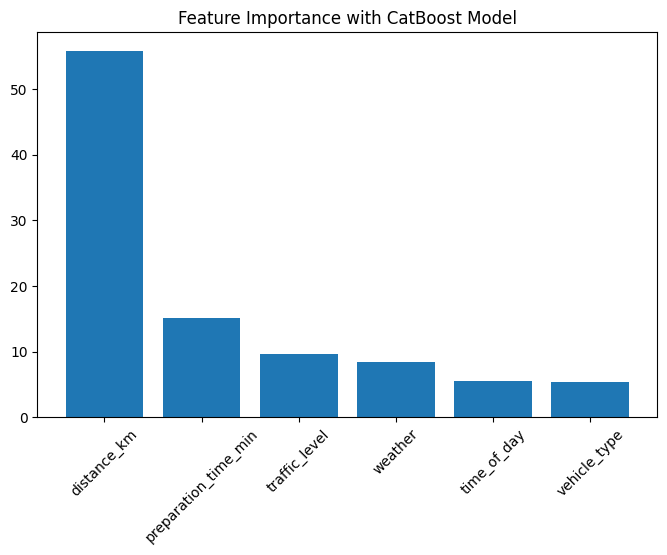

In [62]:
# feature importance
importances = model.get_feature_importance()
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(8,5))
plt.bar([X_train.columns[i] for i in sorted_idx], importances[sorted_idx])
plt.title("Feature Importance with CatBoost Model")
plt.xticks(rotation=45)
plt.show()